In [1]:
import pandas as pd
df = pd.read_csv('flightdata.csv')
df = df.drop('Unnamed: 25', axis=1)
df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]]
df = df.fillna({"ARR_DEL15":1})


In [2]:
import math
for index, row in df.iterrows():
    df.loc[index,"CRS_DEP_TIME"] = math.floor(row["CRS_DEP_TIME"]/100)
df = pd.get_dummies(df, columns= ['ORIGIN','DEST'])

In [3]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop("ARR_DEL15", axis=1), df['ARR_DEL15'], test_size=0.2, random_state=42)
test_y.shape

(2247,)

In [5]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=13)
model.fit(train_x,train_y)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [6]:
predict = model.predict(test_x)
model.score(test_x,test_y)

0.8602581219403649

In [10]:
from sklearn.metrics import roc_auc_score
prob = model.predict_proba(test_x)
roc_auc_score(test_y,prob[:,1])

0.6743824904998539

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predict)

array([[1882,   54],
       [ 260,   51]])

In [17]:
from sklearn.metrics import precision_score
train_predicts = model.predict(train_x)
precision_score(train_y,train_predicts)

0.9972375690607734

In [18]:
from sklearn.metrics import recall_score
recall_score(train_y,train_predicts)

0.8650159744408946

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


[[0.8 0.2]
 [0.9 0.1]
 [1.  0. ]
 ...
 [0.9 0.1]
 [0.7 0.3]
 [1.  0. ]]


Text(0, 0.5, 'Precisão do verdadeiro positivo')

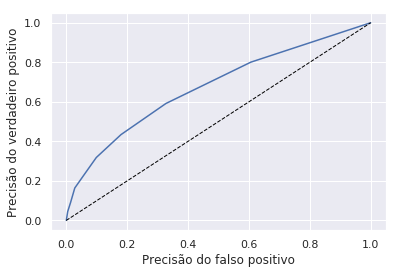

In [26]:
from sklearn.metrics import roc_curve
print(prob)
falso_positivo, verdadeiro_positivo, _ = roc_curve(test_y, prob[:, 1]) #montando o gráfico apenas com a precisão dos dados relevantes
plt.plot(falso_positivo, verdadeiro_positivo)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('Precisão do falso positivo')
plt.ylabel('Precisão do verdadeiro positivo')

In [29]:
from datetime import datetime
def previsao(data,origem, destino):
    try:
        dataFormatada = datetime.strptime(data, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)
    mes = dataFormatada.month
    dia = dataFormatada.day
    hora = dataFormatada.hour
    dia_da_semana = dataFormatada.isoweekday()
    
    origem = origem.upper()
    destino = destino.upper()
    input = [{'MONTH': mes,
              'DAY': dia,
              'DAY_OF_WEEK': dia_da_semana,
              'CRS_DEP_TIME': hora,
              'ORIGIN_ATL': 1 if origem == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origem == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origem == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origem == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origem == 'SEA' else 0,
              'DEST_ATL': 1 if destino == 'ATL' else 0,
              'DEST_DTW': 1 if destino == 'DTW' else 0,
              'DEST_JFK': 1 if destino == 'JFK' else 0,
              'DEST_MSP': 1 if destino == 'MSP' else 0,
              'DEST_SEA': 1 if destino == 'SEA' else 0 }]
    return model.predict_proba(pd.DataFrame(input))[0][0]

In [36]:
previsao('21/07/2020 21:45:00', 'JFK', 'ATL')

0.8

(0.0, 1.0)

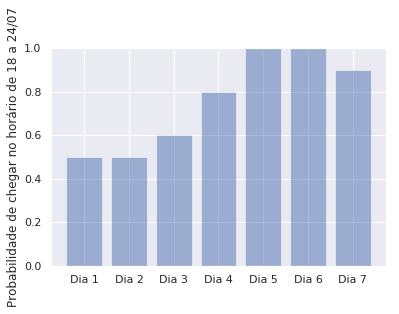

In [39]:
import numpy as np
labels=("Dia 1","Dia 2","Dia 3","Dia 4","Dia 5","Dia 6","Dia 7",)
valores = (previsao('18/07/2020 21:45:00', 'JFK', 'ATL'),
          previsao('19/07/2020 21:45:00', 'JFK', 'ATL'),
           previsao('20/07/2020 21:45:00', 'JFK', 'ATL'),
          previsao('21/07/2020 21:45:00', 'JFK', 'ATL'),
          previsao('22/07/2020 21:45:00', 'JFK', 'ATL'),
          previsao('23/07/2020 21:45:00', 'JFK', 'ATL'),
          previsao('24/07/2020 21:45:00', 'JFK', 'ATL'),)
alabels = np.arange(len(labels))
plt.bar(alabels, valores, align='center', alpha = 0.5)
plt.xticks(alabels,labels)
plt.ylabel("Probabilidade de chegar no horário de 18 a 24/07")
plt.ylim((0.0, 1.0))